# Research question 3 : What is the magnitude of the presence of climate change quotes compared to other significant topics ?

In this notebook we will study how much the climate change was represented in the media on a quotation level. To do that we will research into the amount of quotes made last year regarding the environment and compare them with other topics.
## Setup

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import bz2
import json
import matplotlib.pyplot as plt
from processing import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from datetime import datetime

from tld import get_tld
#from google.colab import drive
#drive.mount('/content/drive')

#PATH_ROOT = '/content/drive/MyDrive/ADA'
PATH_ROOT = 'data'
PATH_PARQUET = PATH_ROOT + '/project_datasets'
PATH_QUOTEBANK = PATH_ROOT + '/Quotebank'
PATH_TO_QUOTES = PATH_QUOTEBANK + '/quotes-{year}.json.bz2'
PATH_TO_WORDS = PATH_ROOT + '/Keywords'
PATH_TO_ENVIRONMENT_WORDS = PATH_TO_WORDS + "/environment_keywords.txt"
PATH_TO_LGBT_WORDS = PATH_TO_WORDS + "/lgbt_keywords.txt"
PATH_TO_BREXIT_WORDS = PATH_TO_WORDS + "/brexit_keywords.txt"
PATH_TO_DATA_SCIENCE_WORDS = PATH_TO_WORDS + "/data_science_keywords.txt"
PATH_TO_GUN_CONTROL_WORDS = PATH_TO_WORDS + "/gun_control_keywords.txt"

%matplotlib inline
%reload_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 5000, 'display.max_rows',1000)

---

## Loading the dataset

We begin by loading our data

In [2]:
time = []
time.append(datetime.now())
data = pd.read_json(path_or_buf="data/Quotebank/quotes-2020.json.bz2", compression='bz2', lines=True, chunksize = 5000000)
quotes = pd.concat(data)
time.append(datetime.now())
elapsed_time = time[1]-time[0]
print("Time needed for the dataset to load : {}".format(elapsed_time))

Time needed for the dataset to load : 0:17:20.020760


In this analysis we will not need a number of the attributes for the quotebank dataset : [numOccurences, probas, phase]

In [3]:
quotes.drop(columns = ["numOccurrences", "probas", "phase"], inplace = True)
quotes.set_index("quoteID", inplace = True)

---
## Plotting the original data

A short preview of our initial dataset : 

In [4]:
display(quotes.head())

,quotation,speaker,qids,date,urls
quoteID,,,,,
2020-01-28-000082,"[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,",None,[],2020-01-28 08:04:05,[http://israelnationalnews.com/News/News.aspx/275210]
2020-01-16-000088,[ Department of Homeland Security ] was livid and strongly urged to have the agenda pulled.,Sue Myrick,[Q367796],2020-01-16 12:00:13,[http://thehill.com/opinion/international/478224-saudi-critics-should-revisit-sue-myricks-wake-up-america-agenda]
2020-02-10-000142,"... He (Madhav) also disclosed that the illegal bribe amount is collected from transporters through various middlemen and the same is collected by one Sh Madan Garg, GSTO, who distributes the shares of all officers, including one Sh Udit Prakash Rai, IAS, AGMUT...",None,[],2020-02-10 23:45:54,[https://indianexpress.com/article/business/economy/cbi-to-court-gst-officials-taking-cut-from-transporters-6261429/]
2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,"[https://patriotpost.us/opinion/68622-trump-budget-a-cut-above-the-rest-2020-02-15, https://www.lifenews.com/2020/02/15/nancy-pelosi-and-democrats-push-bill-to-overturn-every-pro-life-law-saving-babies-from-abortions/]"
2020-01-24-000168,[ I met them ] when they just turned 4 and 7. They were little. They felt like my full-blown stepkids.,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,"[https://people.com/parents/meghan-king-edmonds-not-using-frozen-embryos-with-jim-edmonds/, https://people.com/parents/meghan-king-edmonds-stepkids-poisoned-false-information-about-her-jim-edmonds/, https://www.usmagazine.com/celebrity-news/news/meghan-king-edmonds-says-shes-been-blocked-from-stepkids/, https://people.com/tv/meghan-king-edmonds-jim-edmonds-came-with-baggage-kids/]"


## Getting the domain 

Our first step is to extract the domains from the given dataset. We do that using the feature "urls" and the function *set_domains*. As a result, a new feature called "domains" is created. An example of the url to domain transformation is : 
-    https://www.nytimes.com -> nytimes

After this is done the "urls" feautre is no longer required so we delete it.

In [5]:
quotes["domains"] = quotes["urls"].apply(set_domains)
quotes.drop(columns=["urls"],inplace = True)

## Labeling the data
We move on to labeling our data. We do this using our filter function : *topic_filtering*. This function creates a new feautere depending on the topic with possible values : 
- 1 : The quote is related to the topic
- 0 : The quote is not related with the topic

This id done by giving a .txt file containing words associated with the investigated topic to the function. If any of these words, are included in the quote then the quote is marked as related with the topic.A more preferable method would be using a more complex topic detection model like BERT. However, due to many reasons such as time, computation constraints, size of the dataset and our own lack of experience as to how to handle such models, we chosse not to.

The topics that we chose to follow are : 
- LGBT Rights
- Brexit
- Gun control

We chose these topics because in the same way as the climate change they are polarizing issues with multiple levels such as social or ethical standpoints and potential devastating effects on the community. 

In [6]:
topic_filtering(quotes, "Environment", PATH_TO_ENVIRONMENT_WORDS)
print("The environment labeling is done")
topic_filtering(quotes, "LGBT", PATH_TO_LGBT_WORDS)
print("The LGBT labeling is done")
topic_filtering(quotes, "Brexit", PATH_TO_BREXIT_WORDS)
print("The Brexit labeling is done")
topic_filtering(quotes, "Gun_Control", PATH_TO_GUN_CONTROL_WORDS)
print("The Gun control labeling is done")

The environment labeling is done
The LGBT labeling is done


/Users/nearchospotamitis/Desktop/ada-2021-project-comic-sans/processing.py:27: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df["quotation"].str.contains('|'.join(lines),case = False),column_name]=1


The Brexit labeling is done
The Gun control labeling is done


## Topic analysis in total

In [7]:
quotes_env = quotes[quotes["Environment_related"]==1]
quotes_lgb = quotes[quotes["LGBT_related"]==1]
quotes_bre = quotes[quotes["Brexit_related"]==1]
quotes_gun = quotes[quotes["Gun_Control_related"]==1]

### Total quotes per topic
Our first step is to compare the total amount of quotes published for each topic.

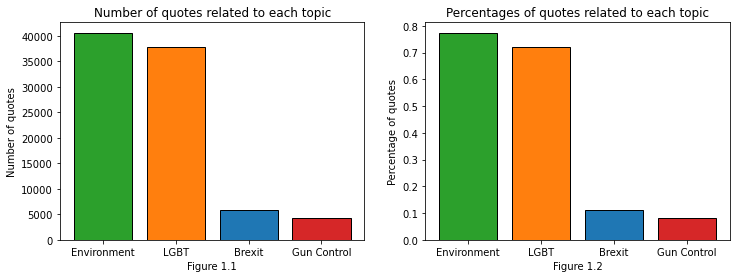

In [8]:
topic_of_quotes = ["Environment", "LGBT", "Brexit", "Gun Control"]
number_of_quotes = np.array([quotes_env.shape[0], quotes_lgb.shape[0], quotes_bre.shape[0], quotes_gun.shape[0]])
percentage_of_quotes = np.array([quotes_env.shape[0], quotes_lgb.shape[0], quotes_bre.shape[0], quotes_gun.shape[0]])/quotes.shape[0]*100

plt.figure(figsize = (12,4))
plt.subplot(121)
plot_total = plt.bar(topic_of_quotes, number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.title("Number of quotes related to each topic")
plt.xlabel("Figure 1.1")
plt.ylabel("Number of quotes")

plt.subplot(122)
plot_total = plt.bar(topic_of_quotes, percentage_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.title("Percentages of quotes related to each topic")
plt.xlabel("Figure 1.2")
plt.ylabel("Percentage of quotes")
plt.show()

### Frequency of each topic

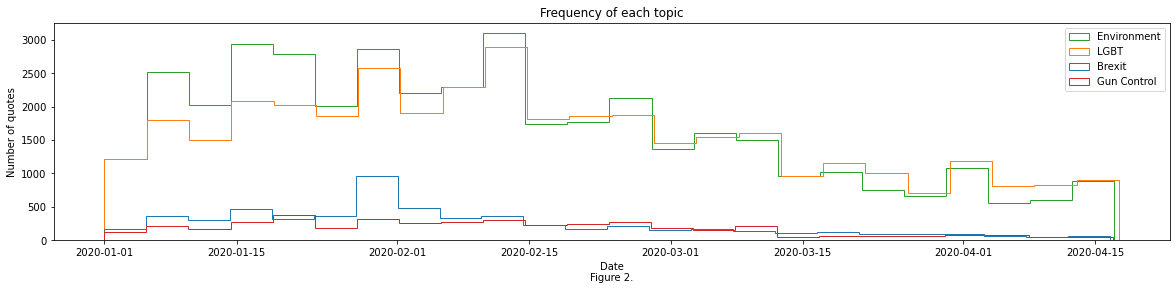

In [9]:
plt.figure(figsize = (20,4))
plt.hist(quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure 2.""")
plt.ylabel("Number of quotes")
plt.title("Frequency of each topic")
plt.legend()
plt.show()

In the above graph we can see the amount of quotes related to each topic along the years

## Topic Analysis per media source
Moving on we perform the same analysis as before but now restricted to 1 media source. Our goal is to see how each media source represents the climate change issue in comparison with other topics. To achieve this for each media source we plot 3 types of graphs : 
- Type A : This graph represents the total amount of quotes the media published throughout the year
- Type B : This graphs shows how the quotes are distributed for each topic taking in account only quotes related to these 4 topics. It also displays as a means of comparison the same distribution but for all media and not only limited to one.
- Type C : This graphs displays the amount of quotes related to each topic, published by the media in a certain time period.

For our analysis we wanted to use media sources covering as much of the journalism spectrum ideology as we could. Since our dataset covers mostly U.S. newspapers we focused on media sources located in the U.S.A. that are being prefered by mostly liberal readers going to mostly conservative readers. We did this depending on :
1. Main media source preferred for each ideological group ([related research](https://www.pewresearch.org/journalism/2014/10/21/political-polarization-media-habits/pj_14-10-21_mediapolarization-02/))
2. The trust level of each media source for each for each ideological group ([related research](https://www.pewresearch.org/journalism/2014/10/21/political-polarization-media-habits/pj_2014-10-21_media-polarization-01/))

Based on these factors the media sources we chose going from most liberal to most conservative are : CNN, The New York times, Fox News, the Breitbart News Network. Finally, we also included The Guardian as a british newspaper to serve as an independent factor. 

### 1) CNN

In [10]:
cnn_quotes = quotes[quotes["domains"].apply(check_domain, args = ("cnn",))]
cnn_quotes_env = cnn_quotes[cnn_quotes["Environment_related"]==1]
cnn_quotes_lgb = cnn_quotes[cnn_quotes["LGBT_related"]==1]
cnn_quotes_bre = cnn_quotes[cnn_quotes["Brexit_related"]==1] 
cnn_quotes_gun = cnn_quotes[cnn_quotes["Gun_Control_related"]==1] 

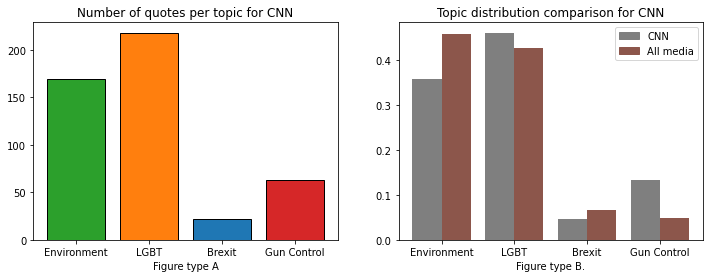

In [11]:
cnn_number_of_quotes = np.array([cnn_quotes_env.shape[0], cnn_quotes_lgb.shape[0], cnn_quotes_bre.shape[0], cnn_quotes_gun.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, cnn_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.title("Number of quotes per topic for CNN")
plt.xlabel("Figure type A")
plt.subplot(122)
colors = {"CNN":'tab:grey', 'All media':'tab:brown'} 
subcategorybar(topic_of_quotes, [cnn_number_of_quotes, number_of_quotes], colors,"type B", media = "CNN")
plt.show()

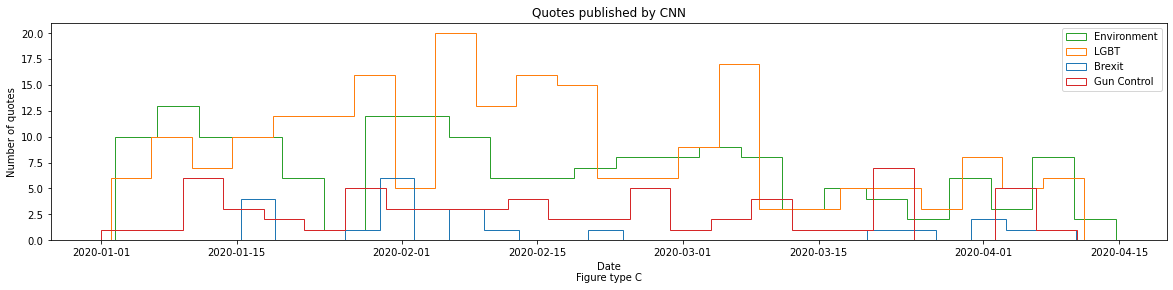

In [12]:
plt.figure(figsize = (20,4))
plt.hist(cnn_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(cnn_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(cnn_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(cnn_quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure type C""")
plt.ylabel("Number of quotes")
plt.title("Quotes published by CNN")
plt.legend()
plt.show()

### 2) The New York Times

In [13]:
nytimes_quotes = quotes[quotes["domains"].apply(check_domain, args = ("nytimes",))]
nytimes_quotes_env = nytimes_quotes[nytimes_quotes["Environment_related"]==1]
nytimes_quotes_lgb = nytimes_quotes[nytimes_quotes["LGBT_related"]==1]
nytimes_quotes_bre = nytimes_quotes[nytimes_quotes["Brexit_related"]==1] 
nytimes_quotes_gun = nytimes_quotes[nytimes_quotes["Gun_Control_related"]==1] 

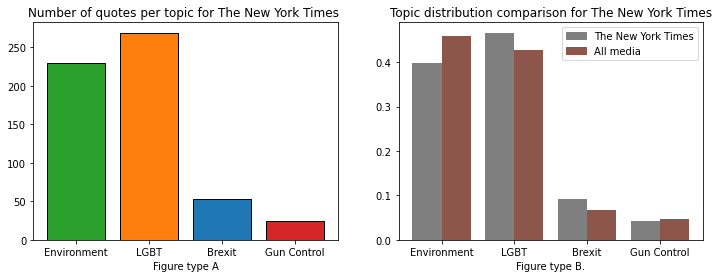

In [14]:
nytimes_number_of_quotes = np.array([nytimes_quotes_env.shape[0], nytimes_quotes_lgb.shape[0], nytimes_quotes_bre.shape[0], nytimes_quotes_gun.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, nytimes_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.title("Number of quotes per topic for The New York Times ")
plt.xlabel("Figure type A")
plt.subplot(122)
colors = {"The New York Times":'tab:grey', 'All media':'tab:brown'} 
subcategorybar(topic_of_quotes, [nytimes_number_of_quotes, number_of_quotes], colors,"type B", media = "The New York Times")
plt.show()

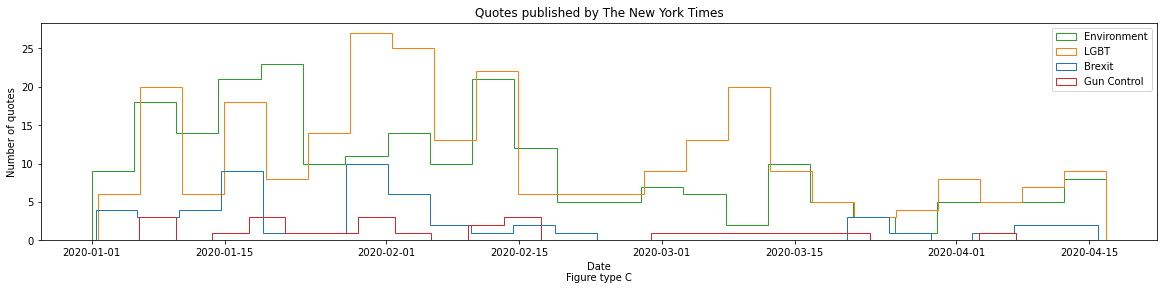

In [15]:
plt.figure(figsize = (20,4))
plt.hist(nytimes_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(nytimes_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(nytimes_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(nytimes_quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure type C""")
plt.ylabel("Number of quotes")
plt.title("Quotes published by The New York Times")
plt.legend()
plt.show()

### 3) Fox News

In [16]:
foxnews_quotes = quotes[quotes["domains"].apply(check_domain, args = ("foxnews",))]
foxnews_quotes_env = foxnews_quotes[foxnews_quotes["Environment_related"]==1]
foxnews_quotes_lgb = foxnews_quotes[foxnews_quotes["LGBT_related"]==1]
foxnews_quotes_bre = foxnews_quotes[foxnews_quotes["Brexit_related"]==1]
foxnews_quotes_gun = foxnews_quotes[foxnews_quotes["Gun_Control_related"]==1] 

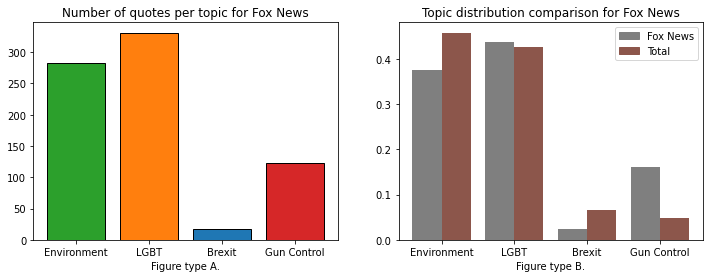

In [17]:
foxnews_number_of_quotes = np.array([foxnews_quotes_env.shape[0], foxnews_quotes_lgb.shape[0], foxnews_quotes_bre.shape[0], foxnews_quotes_gun.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, foxnews_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.xlabel("Figure type A.")
plt.title("Number of quotes per topic for Fox News")
plt.subplot(122)
colors = {"Fox News":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [foxnews_number_of_quotes, number_of_quotes], colors, "type B", media = "Fox News")
plt.show()

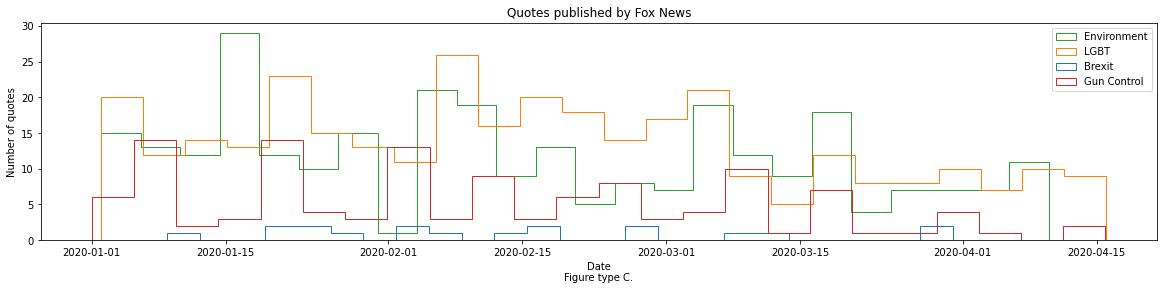

In [18]:
plt.figure(figsize = (20,4))
plt.hist(foxnews_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(foxnews_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(foxnews_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(foxnews_quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure type C.""")
plt.ylabel("Number of quotes")
plt.title("Quotes published by Fox News")
plt.legend()
plt.show()

### 4) Breitbart News Network

In [19]:
breitbart_quotes = quotes[quotes["domains"].apply(check_domain, args = ("breitbart",))]
breitbart_quotes_env = breitbart_quotes[breitbart_quotes["Environment_related"]==1]
breitbart_quotes_lgb = breitbart_quotes[breitbart_quotes["LGBT_related"]==1]
breitbart_quotes_bre = breitbart_quotes[breitbart_quotes["Brexit_related"]==1] 
breitbart_quotes_gun = breitbart_quotes[breitbart_quotes["Gun_Control_related"]==1] 

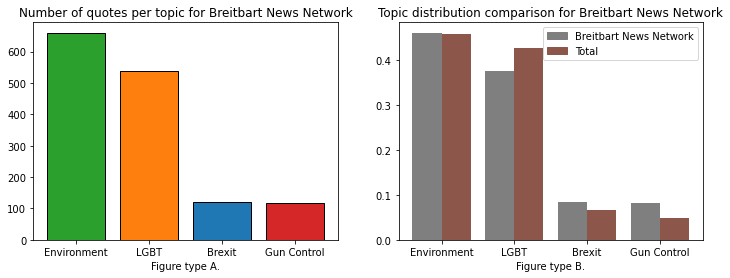

In [20]:
breitbart_number_of_quotes = np.array([breitbart_quotes_env.shape[0], breitbart_quotes_lgb.shape[0], breitbart_quotes_bre.shape[0],breitbart_quotes_gun.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, breitbart_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.xlabel("Figure type A.")
plt.title("Number of quotes per topic for Breitbart News Network")
plt.subplot(122)
colors = {"Breitbart News Network":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [breitbart_number_of_quotes, number_of_quotes], colors,"type B", media = "Breitbart News Network")
plt.show()

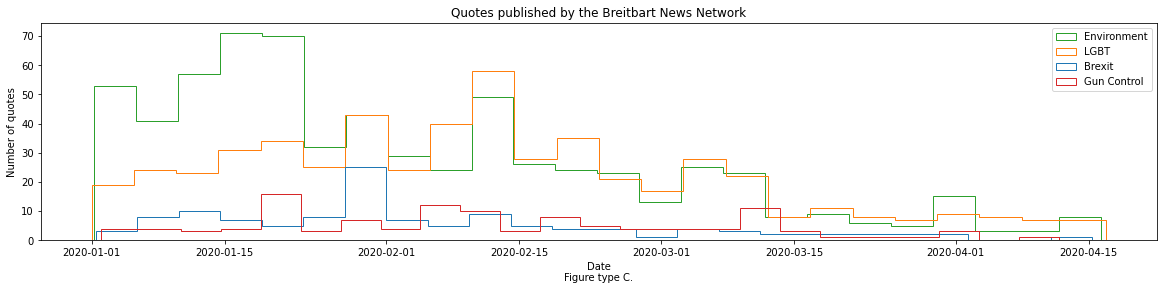

In [21]:
plt.figure(figsize = (20,4))
plt.hist(breitbart_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(breitbart_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(breitbart_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(breitbart_quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure type C.""")
plt.ylabel("Number of quotes")
plt.title("Quotes published by the Breitbart News Network")
plt.legend()
plt.show()

### 5) The Guardian

In [22]:
theguardian_quotes = quotes[quotes["domains"].apply(check_domain, args = ("theguardian",))]
theguardian_quotes_env = theguardian_quotes[theguardian_quotes["Environment_related"]==1]
theguardian_quotes_lgb = theguardian_quotes[theguardian_quotes["LGBT_related"]==1]
theguardian_quotes_bre = theguardian_quotes[theguardian_quotes["Brexit_related"]==1]
theguardian_quotes_gun = theguardian_quotes[theguardian_quotes["Gun_Control_related"]==1] 

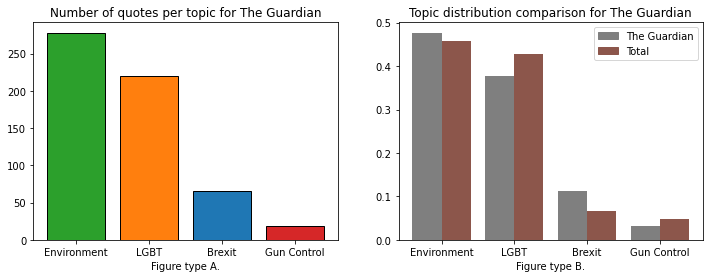

In [23]:
theguardian_number_of_quotes = np.array([theguardian_quotes_env.shape[0], theguardian_quotes_lgb.shape[0], theguardian_quotes_bre.shape[0], theguardian_quotes_gun.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, theguardian_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue", "tab:red"])
plt.xlabel("Figure type A.")
plt.title("Number of quotes per topic for The Guardian")
plt.subplot(122)
colors = {"The Guardian":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [theguardian_number_of_quotes, number_of_quotes], colors, "type B", media = "The Guardian")
plt.show()

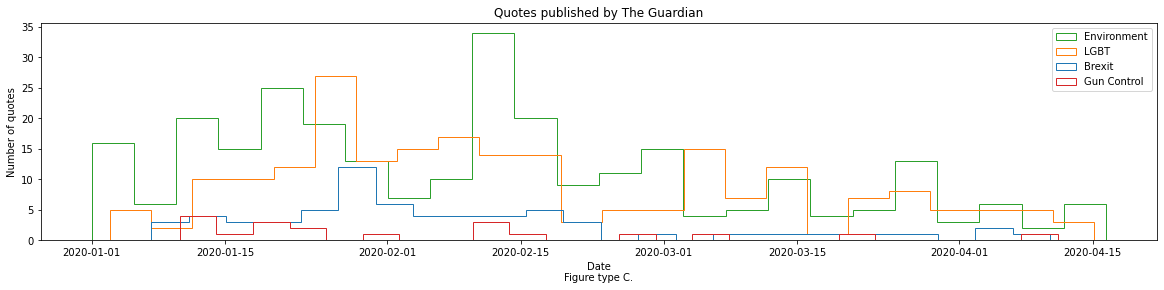

In [24]:
plt.figure(figsize = (20,4))
plt.hist(theguardian_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(theguardian_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(theguardian_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.hist(theguardian_quotes_gun["date"], histtype = "step", label = "Gun Control", color = "tab:red", bins = 24)
plt.xlabel("""Date
Figure type C.""")
plt.ylabel("Number of quotes")
plt.title("Quotes published by The Guardian")
plt.legend()
plt.show()

### Summary
Finally, we summarize by plotting all type B plots on the same graph so we can draw some conclusions:

<Figure size 576x576 with 0 Axes>

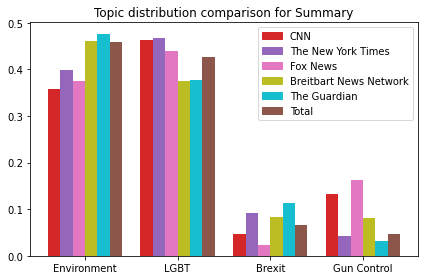

In [95]:
plt.figure(figsize = (8,8))
colors = {"CNN":'tab:red', "The New York Times":'tab:purple', "Fox News":'tab:pink', 
          "Breitbart News Network":'tab:olive', "The Guardian":'tab:cyan', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [cnn_number_of_quotes, nytimes_number_of_quotes, foxnews_number_of_quotes, 
                                 breitbart_number_of_quotes, theguardian_number_of_quotes, number_of_quotes],colors, "19", media = "Summary")
plt.show()

What we can see here is that the more conservative-trusted media sources tend to publish quotes related to the environment more than for the other topics that we have researched.

## Wordcloud

 Word Clouds are visual representations of words that give greater prominence to words that appear more frequently. In other *words*, they display the most defining words in a text. Moving on we created a word cloud for each topic based on the quotes relevant to it. 

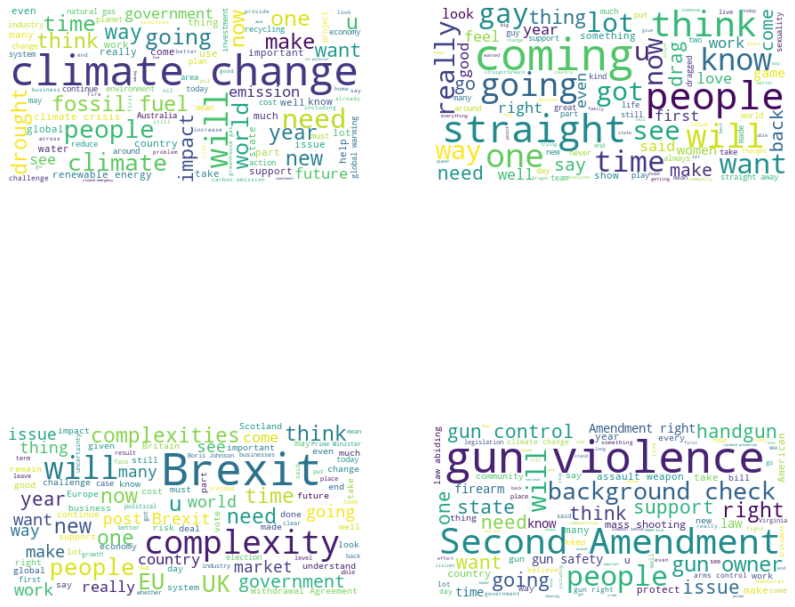

In [26]:
text_env = " ".join(review for review in quotes_env.quotation)
text_lgb = " ".join(review for review in quotes_lgb.quotation)
text_bre = " ".join(review for review in quotes_bre.quotation)
text_gun = " ".join(review for review in quotes_gun.quotation)

wordcloud_env = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_env)
wordcloud_lgb = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_lgb)
wordcloud_bre = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_bre)
wordcloud_gun = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_gun)

plt.figure(figsize = (14,14))
plt.subplot(221)
plt.imshow(wordcloud_env, interpolation='bilinear')
plt.axis("off")
plt.subplot(222)
plt.imshow(wordcloud_lgb, interpolation='bilinear')
plt.axis("off")
plt.subplot(223)
plt.imshow(wordcloud_bre, interpolation='bilinear')
plt.axis("off")
plt.subplot(224)
plt.imshow(wordcloud_gun, interpolation='bilinear')
plt.axis("off")
plt.show()

Simple methods often yield simple results but sometimes simple things are not so simple at all. What is the one word included in every word cloud : People. These topics may seem unrelated when you don't pay so much attention. However, they all have an immense impact on the community and the simple people.

## Topic analysis per group of people
Our next step is to study the amount of quotes made about the environment from a speaker's point of view. To do that we begin by loading our already processed speakers dataset : 

In [27]:
speakers = pd.read_parquet('data/Speakers/speakers_labeled.parquet.gzip')

In [28]:
speakers.head(4)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washington, Father of the United States, The American Fabius]",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[None],W000178,"[politician, military officer, farmer, cartographer, land surveyor, engineer, statesperson, slaveholder]",[independent politician],[None],George Washington,"[1792 United States presidential election, 1788–89 United States presidential election]",item,[Episcopal Church],289.0,>=100
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Douglas N. Adams]",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children's writer, science fiction writer, comedian, writer]",[None],[None],Douglas Adams,[None],item,[None],69.0,60s
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[None],None,"[writer, lawyer, librarian, information scientist, inventor, bibliographer]",[None],[None],Paul Otlet,[None],item,[None],153.0,>=100
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bush 43, President George W. Bush, George Bush, President Bush, Bush, Bush, George W.]",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiographer, painter, rugby union player, military officer, statesperson, businessperson, financier]",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 2004 United States presidential election, 1998 Texas gubernatorial election, 1978 United States House of Representatives elections]",item,"[United Methodist Church, Episcopal Church, Methodism]",75.0,70s


For this task we need to know the exact speaker that made the quote because we will be looking into hers/his background. For some cases our dataset presents 2 problems : 
-1. The first problem is that for some quotes we do not know for sure what the name of the speaker is. Our solution is to drop all quotes whose speaker doesn't have a name.
-2. Even if we know the speaker's name we might not know for sure who the actual person is. In this case the speakers has multiple qids. Our solution is to drop all quotes that are made by a speaker with multiple qids.

We make these changes to our dateset : 

In [29]:
quotes_size = []
quotes_size.append(quotes.shape[0])
quotes.drop(quotes[quotes.speaker == "None"].index, inplace=True)
quotes = quotes[quotes.qids.apply(check_qids)]
quotes.rename(columns = {"qids":"qid"}, inplace = True)
quotes = quotes.explode("qid")
quotes_size.append(quotes.shape[0])

The next step is to merge our datasets together : For each quote we have the attributes of the person that made it.

In [30]:
quoters = pd.merge(left = quotes, right = speakers, left_on="qid", right_index=True)

---
In this analysis we will proceed in the following way : First we will group people based on a common attribute. Then for each of these groups we will plot the percentage of the quotes that they made which are related to the environment in comparison to the total amount of quotes made by the same group. By doing that we want to answer the following question : How much of their quotes is each group dedicating to the environment ?
### Common Attribute : Occupation 

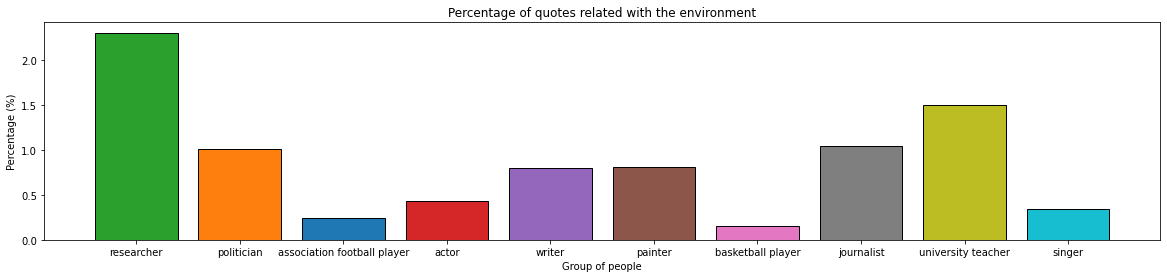

In [93]:
plot_env_group_percentage(quoters, ["researcher","politician", "association football player", "actor", "writer", 
                                          "painter", "basketball player", "journalist", "university teacher", "singer"], "occupation")

From this graphs that we can see that the group that has the biggest percentage of quotes related to the environment are the researchers followed by the university teachers and then by the politicians and the journalists. It's only natural to presume that the researchers and the university teachers are the ones with the most knowledge regarding the climate change. Following that thought, we can see that the people who undertand most about this issue are the ones speaking more about it. On the other hand, athletes are at the bottom of this list. What is interesting is that politicians are a bit close to the middle of the least. Of course, that is understandable as the have to deal with all issues and talk about many different stuff. However, the climate change is a problem that affects our lives right now and will keep affecting them more and more as the time goes by. Because of that, maybe they could take the example of the "science's side" and be more supportive to this cause.

### Common Attribute : Political party

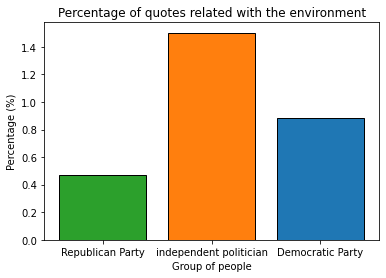

In [92]:
plot_env_group_percentage(quoters, ["Republican Party", "independent politician", "Democratic Party"], "party")

From our latest results we can see some big differences as to how much each political party decides to represent the enironment. Starting from the Republicans, going to the Democrats and then to the Independent politicians every time the percentage of quotes dedicated to the environment almost doubles.
### Common Attribute : Nationality

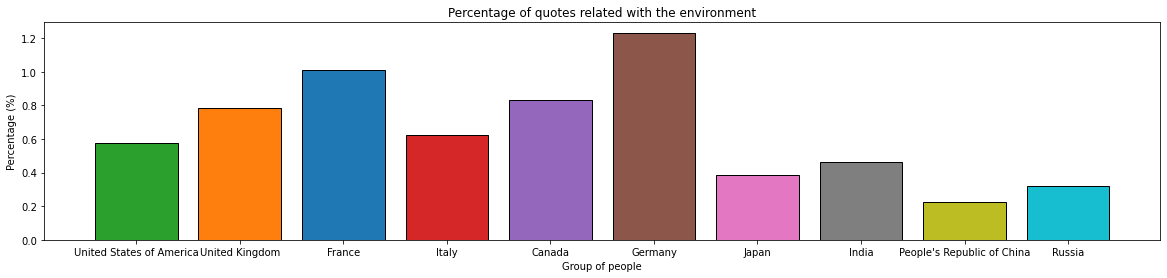

In [91]:
plot_env_group_percentage(quoters, ["United States of America","United Kingdom", "France", "Italy", "Canada",
                                     "Germany", "Japan", "India", "People's Republic of China", "Russia"], "nationality")

In the end, we can see that the people most willing to dedicate their quotes to the environment are the ones from Europe and Canada, followed by the U.S.A. and then from Asia.